# Introduction

During the 2021 United Nations Climate Change Conference a report was published stating that 'Air pollution is the largest environmental risk to the public’s health, contributing to cardiovascular disease, lung cancer and respiratory diseases. It is costing the UK economy £20 billion a year and contributes to over 25,000 deaths a year' $^{1}$. However, this report could be masking a bigger issue of air polution worldwide. An OECD report published in 2016 states that air pollution costs 1% of GDP each year and accounts for 9 million premature deaths $^{2}$.

With the human population growing at an exponential rate, it would seem, we now find ourselves in a continous loop. The Malthusian model, commonly used in development econmics, looks to model population growth. As a country grows, food production, basic industry and infrastructure grow to service the population until an equilibrium level is reached. There are two takeaways from the model relating to air pollution. Firstly, air pollution does not cost and is in essence free to 'produce' implying there is no constraint on air pollution. Moreover, as less economically developed countries accelerate towards their equilibrium state, industry will have to keep up and air pollution is predicted to get worse.

This being said, there appears to be other factors that affect air pollution. Global warming is well documented, however, the secondary and tertiary impacts on air pollution are less clear. Wildfires raged across Greece in August 2021, with the problem stemming from unusually hot and long summers. The Guardian reported that 'the fires were some of the worst on record' $^{3}$. Wildfires produce high amounts of black carbon, carbon dioxide, ozone precursors and black carbon into the atmosphere, causing air quality to plummet. 

However, with evolving winds, humidity levels and precipitation rates, areas once crippled by air pollution may soon see clearer skies while air pollution is involuntarily dumped onto other cities in a game of air pollution roulette. 

In this report we will look in depth at the factors above namely: demographics, weather and events. The report will aim to highlight areas of interest related to these factors in three countries: Mexico, UK and Iceland - representing an emerging nation and two developed nations with very different weather dynamics, industry and natural resources.  

The report will focus upon 2 key measurements particulate matter 10 ($pm_{10}$) and particulate matter 25 ($pm_{25}$). These are defined as particulate matter that is smaller than 10 micrometres and 25 micrometres respectively. These were chosen given the breadth of activities that produce $pm_{10}$ and $pm_{25}$. The main contributor to $pm_{10}$ and $pm_{25}$ is the burning of oil, fuel and wood, however, $pm_{10}$ and $pm_{25}$ also include dust from industrial activity, landfill sites and even smaller bacteria. The wide range of polluting activities emitting these particulates will allow us to examine, explore and analyse the three nations in depth. 

Finally, we aim to predict air quality in a certain city for an upcoming day given the weather conditions using a simple classifier.



$^{1}$ http://www.local.gov.uk/parliament/briefings-and-responses/cop26-and-impact-air-pollution-public-health-and-wellbeing-house

$^{2}$ OECD (2016), The Economic Consequences of Outdoor Air Pollution, OECD Publishing, Paris, https://doi.org/10.1787/9789264257474-en.

$^{3}$ https://www.theguardian.com/world/2021/sep/30/its-like-a-war-greece-battles-increase-in-summer-wildfires

# Data & Measurements

Most of the data in this report and prediction model comes from two APIs. One for weather and one for pollution.
We wrapped both of them in functions that call the APIs, parse the response and return appropriate data frames.
In addition to returning the data asked for, our functions also store the data in CSV files under ./data in the project directory. This is done to reduce network requests and also to be able to verify and explore the data in raw format.

If a CSV file exists for the city requested by the user, and it contains all the rows for the queried dates, the CSV file is returned and the API is not called.


### Weather
The source for weather data is the meteostat API found here [meteostat python](https://dev.meteostat.net/python/). It has a convenient python library that allows the user to query for historical weather data for a particular location during a specified time interval.
The python library automatically collects data from different weather stations and bundles them together. 
For the purpose of this report, we need to transform the data before using it. For example, we are only interested in a subset of all the data in the response. Futhermore, to ease usage of our model, our users should only provide a city name. However, the meteostat library only accepts latitude and longitude coordinates. 
To facilitate this, prior to using the meteostat API, we call a geocoding API from open-meteo.com [open-meteo geocoding](https://open-meteo.com/en/docs/geocoding-api). It accepts a city name and returns all cities that match the name and their geographic latitude and longitude coordinates. 

The results from the open-meteo API are global. This means that if multiple cities share the same name, they are all in the API response. Because of this, we filter the results down to a particular country, and assume that if our user ask for 'London' she means London UK, not London New York USA. In addition, of all the cities that match a given country, we assume the user wants the most populated city.

Armed with the latitude and longitude for the city the user wants to know about, we then call the meteostat API. 
As mentioned before, if we already have CSV data locally for the required range, instead of going through all that was mentioned above, we return the appropriate data from the CSV file.

### Pollution
The source for pollution data is [OpenAq](https://openaq.org/#/), a non profit that is focused on air quality. A [python library](http://dhhagan.github.io/py-openaq/generated/openaq.OpenAQ.measurements.html#openaq.OpenAQ.measurements) exists, py-openaq, which we use for convenience. We use it in a similar way that we use the meteostat API. We use the same code to look up geographical coordinates from city names. Then we call the OpenAq library using the coordinates.

The OpenAq library returns a panda dataframe with historical pollution data for many different pollutants. We filter by date, pollutant, and location. The API supports pagination, but in practice we have found that it does not work. Because of this, we instead break up the date ranges in blocks of 30 days and query one block at a time.

The API is also very slow and sometimes goes down for periods of time. This is another reason for storing the responses in CSV files.
OpenAq collects a massive amount of readings. Since there is plenty of data, we filter out all readings that are not done by the government so the data we use is of higher quality. We would prefer to do this at the request level(as the [HTTP api](https://docs.openaq.org/#/v2/measurements_get_v2_measurements_get) supports), but sadly the python library does not offer that feature.

### Demographic analysis

Population data was sourced through 'The World Bank' (https://www.worldbank.org/en/home). Given the relatively static nature of population data, it was decided that daily, weekly or monthly data was not needed. Moreover, sourcing population data through an API was problematic given as city level data was needed for initial analysis. A few APIs were found, however, data for cities such as Reykjavik was hard to come by. It was decided that adding data to CSV files and reading them into a pandas dataframe was most efficient. Population from the World Bank was checked against multiple sources for the cities in question.

Alongside general population data, GDP and population density data were also sourced from the World Bank. While alternative sources were considered it was deemed important to take demographic data from one location given the interdependence of certain statistics. For example, population density is dependent on population statistics. Had data been taken from an alternative sources any data analysis would have been left void as a result. 

Below is the code for our 2 API wrappers and all the helper functions they use.



In [2]:
import requests
import pandas as pd
import openaq
import seaborn as sns

import matplotlib.pyplot as plt
from datetime import datetime as dt
from datetime import date
from datetime import timedelta
from meteostat import Point
from meteostat import Daily 

# To filter results, we need to know the country code of a city.
# Scaling the functions to more cities is simple: just add the city and country code
# and then call fetch_weather_data or fetch_pollution_data with the new city name
cities_of_interest = {"Akureyri": "IS", "London": "GB", 
    "Mexico City": "MX", "Newcastle": "GB", "Reykjavík":"IS"}
data_dirs = {"weather": "data/weather", "pollution": "data/pollution"}
data_types = {"pollution", "weather"}

def fetch_data(city_name, data_type, date_from=date.today() - timedelta(days=30), date_to=date.today()):
    '''
    Fetch pollution measurements for a particular city during a particular time.

    Keyword arguments:
    city_name   -- String. The name of the city. E.g. 'London'
    data_type   -- String. Either 'weather' or 'pollution'
    date_from   -- datetime object. The start date we want data for 
    date_to     -- datetime object. The end date we want data for

    Returns:    A dataframe with weather data if data_type == 'weather' and pollution if data_type == 'pollution'
    '''
    if(data_type not in data_types):
        raise ValueError(f"data_type must be one of {data_types}. But was {data_type}")

    city_country = get_city_country(city_name)

    # Since both the weather API and pandas dataframe operate on the datetime level
    # cast date to datetime
    dt_from = cast_date_to_datetime(date_from)
    dt_to = cast_date_to_datetime(date_to)

    pollution = fetch_data_from_csv(data_type, city_country[0], dt_from = dt_from, dt_to = dt_to)

    # If there is no CSV file we call the API
    if(pollution.empty):
        pollution = fetch_data_from_api(data_type, city_country, dt_from, dt_to)
    # If the CSV file doesn't have values for all required dates, update the CSV file 
    elif(needs_more_data(pollution, dt_from, dt_to)):
        pollution = partial_csv_update(data_type, pollution, city_country)
    return pollution 

def cast_date_to_datetime(date):
    '''
    Cast a date object to a datetime object at time 00:00:00

    Keyword arguments:
    date     -- date object.

    Returns:    A datetime object dt where dt.date == date.
    '''
    midnight_time = dt.min.time()
    return dt.combine(date, midnight_time)

def needs_more_data(data, dt_from, dt_to):
    '''
    Returns whether or not data has as many rows as days between dt_from and dt_to

    Keyword arguments:
    data    -- dataframe
    dt_from -- datetime object
    dt_to   -- datetime object

    Returns:    True or False depending on the condition
    '''
    delta_days = (dt_to - dt_from).days + 1
    data_subset = data[(dt_from <= data.index) & (data.index <= dt_to)]
    return len(data_subset) < delta_days

def get_city_country(city_name):
    '''
    Get a tuple with the city_name and country code of the country. Only cities in 'cities_of_interest' are valid.

    Keyword arguments:
    city_name   -- String

    Returns:    A tuple where the first value is the city_name and the second is the country code. E.g. ('London', 'UK')
    '''
    if city_name not in cities_of_interest.keys():
        raise Exception(f"Please enter one of {cities_of_interest}.")
    return (city_name, cities_of_interest[city_name])

def fetch_data_from_csv(type, city_name, **kwargs):
    '''
    Get data from a CSV file. The whole file is returned, unless the keyword arguments 
    'dt_from' and 'dt_to' are supplied. If they are, the results are filtered down to the 
    rows where 'date' lies within those values.

    Keyword arguments:
    type        -- string. Currently supported are 'weather' and 'pollution'
    city_name   -- String
    **kwargs    -- keyword arguments dict. Supported values are 'dt_from' and 'dt_to' and
                they must be datetime objects

    Returns:    A dataframe. If the file is empty or does not exist, the dataframe is empty.
    '''
    file_dir = data_dirs[type]
    
    #Empty dataframe for when there is no csv file
    data = pd.DataFrame({'' : []})

    try:
        data = pd.read_csv(f'{file_dir}/{city_name}.csv', index_col='date', parse_dates=['date'])
        if (kwargs):
            return data[(kwargs['dt_from'] <= data.index) & (data.index <= kwargs['dt_to'])]
    except FileNotFoundError:
        print(f"No historical {type} data found locally. Using API to get fresh data.\n")
    return data

def fetch_data_from_api(type, city_and_country, dt_from, dt_to):
    '''
    Get historical data from an external API within the supplied dates.
    The response contains weather data if type == 'weather' and pollution if type == 'pollution'

    Keyword arguments:
    type                -- string. Currently supported are 'weather' and 'pollution'
    city_and_country    -- Tuple of strings. First value is city_name and second is country code.
    dt_from             -- datetime object
    dt_to               -- datetime object

    Returns:    A dataframe with data from an external API call.
    '''
    city_coords = query_lat_long(city_and_country)

    if (type == 'weather'):
        data = query_historical_weather(city_coords, dt_from, dt_to)
    elif (type == 'pollution'):
        data = query_historical_pollution(city_and_country, dt_from, dt_to)

    # Write new CSV file
    dir_name = data_dirs[type]
    data.to_csv(f'{dir_name}/{city_and_country[0]}.csv')
    return data

def partial_csv_update(type, from_api, city_and_country):
    '''
    Combine data from an existing CSV file and the data in 'from_api'.
    In addition to returning the combined data, we also store it in the same
    CSV file used to combine

    Keyword arguments:
    type                -- string. Currently supported are 'weather' and 'pollution'
    from_api            -- dataframe. The data we got from an external API call.
    city_and_country    -- Tuple of strings. First value is city_name and second is country code.

    Returns:    A dataframe with data from both an external CSV and 'from_api' with duplicates removed.
    '''
    # This is all of our CSV data for the city- no time filter
    from_file = fetch_data_from_csv(type, city_and_country[0])

    total_data = pd.concat([from_file, from_api])
    unique_days = total_data.drop_duplicates()
    unique_days = unique_days.sort_values('date')

    dir_name = data_dirs[type]
    unique_days.to_csv(f'{dir_name}/{city_and_country[0]}.csv')
    return unique_days

def filter_results_to_country(geoapi_response_data, country):
    '''
    Filter data in 'geoapi_response_data' to one item by the following strategy:
    Choose the ones with country code equal to country. From those, choose the one 
    with the highest population.

    Keyword arguments:
    geoapi_response_data    -- dict. The response from geocoding-api on open-meteo. 
                                It must have the following fields: 'country_code', 'population'
                                'latitude', 'longitude'
    country                 -- string. First value is city_name and second is country code.

    Returns:   dict of 'latitude', 'longitude', 'elevation' and 'population' for the matching city.
    '''
    # If there are multiple cities with the same name, we choose the most populated
    filter_by_country = [resp for resp in geoapi_response_data if resp['country_code'] == country]
    
    sorted_by_pop = sorted(filter_by_country, key = lambda resp: resp['population'] if 'population' in resp else 0, reverse=True)
    result = sorted_by_pop[0]

    # Relevant subset of the result dict
    return {key: result[key] for key in ('latitude', 'longitude', 'elevation', 'population')}

def query_lat_long(city_country):
    '''
    Query geocoding API on open-meteo for latitude and longitude coordinates for cities.
    
    Keyword arguments:
    city_country    -- tuple. First value is city_name and second is country code.

    Returns:   dict of 'latitude', 'longitude', 'elevation' and 'population' for the matching city.
               The matching city is the one where country matches city_country[1] and of the cities 
               with the same name, it is the one with the highest population
    '''
    params_dict = {
        'name': city_country[0],
        # Default is 10 but since Newcastle gives 9, we might hit the limit
        'count': 100
    }

    # Since the user gives us more than 3 chars, the API performs fuzzy matching. So we do not
    # need to worry about spelling
    resp = requests.get('https://geocoding-api.open-meteo.com/v1/search', params_dict)
    data = resp.json()
    
    return filter_results_to_country(data['results'], city_country[1])

def query_historical_weather(lat_long_elevation, dt_from, dt_to):
    '''
    Query meteostat for historical weather data at the location in lat_long_elevation during the time range
    between dt_from and dt_to.
    
    Keyword arguments:
    lat_long_elevation  -- dict. 'latitude' and 'longitude' are coordinate values. 'elevation' is the 
                           geographical elevation at that point on the earth.
    dt_from             -- datetime object.
    dt_to               -- datetime object.

    Returns:            Dataframe of historical weather observations. Each row is a single calendar day. 
                        the column names are 'tavg', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres'. They stand for the following:
                        tavg = Temp average (C), prcp = Total precipitation (mm), wdir = Wind direction (degrees),
                        wspd = Average wind speed (km/h), wpgt = Wind peak gust (km/hr), pres = Sea-level air pressure (hpa),
                        rhum = Relative humidity (does not work)
    '''
    
    location = Point(
        lat_long_elevation['latitude'], 
        lat_long_elevation['longitude'], 
        lat_long_elevation['elevation'])

    daily = Daily(location, start=dt_from, end=dt_to)
    
    # Ask meteostat to fill in any gaps in the data
    daily.normalize()
    data = daily.fetch()
    
    # Variables defined in function docstring, see above
    response = data[['tavg', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres']]

    # Since time is an index, simply calling rename does not work
    tidy = response.rename_axis(index={"time": "date"})

    return tidy

def query_historical_pollution(city_country, date_from, date_to):
    '''
    Query OpenAQ for historical pollution data in the city_country city during the time range
    between dt_from and dt_to.
    
    Keyword arguments:
    city_country    -- tuple. First value is city_name and second is country code.
    dt_from         -- datetime object.
    dt_to           -- datetime object.

    Returns:        Dataframe of historical weather observations. Each row represents a calendar day. The index is date.
                    The column names are the following: pm10_mean(float64), pm25_mean(float64), pm10_max(float64)
                    pm25_max(float64), pm10_min(float64), pm25_min(float64)
    '''
    
    # Explicitly use v2 of the API http://dhhagan.github.io/py-openaq/api.html
    api = openaq.OpenAQ(version ='v2')
    # Get the longitude and latitude for the city
    location = query_lat_long(city_country)
    coords = f'{location["latitude"]},{location["longitude"]}'
    
    # Call the location API to check for the first date updated
    locations = api.locations(coordinates = coords,radius = 10000,df = True)

    min_date = locations["firstUpdated"].min()
    min_date = min_date.tz_convert(None)
    min_date = pd.to_datetime(min_date) 
    
    if min_date > date_from:
        date_from = min_date  
    
    # Number of days we want measurements for
    day_diff = (date_to - date_from).days

    # Becaue the pagination of the API does not work, we 
    # need to split the time interval into 30 day chunks. 
    # How we split the call between days to the API
    split_days = 30

    # Number of 30 day blocks in our range
    number_months = day_diff // split_days

    # Initialize the start date
    start = date_from

    # Add measurements data frame 30 days at a time
    # An extra iteration for the remaining < 30 days
    for n in range(number_months + 1):
        
        # Find the end date
        end = start + timedelta(days = split_days)
        
        # Fetch the data from the measurment API
        try:
            df_api = api.measurements(coordinates = coords, radius = 5000, df = True, 
                                        limit = 30000, parameter = ["pm25", "pm10"], value_from = 0,
                                    date_from = start, date_to = end)
        except KeyError:
            print(f"Opanaq API request with coordinates {coords} and date range {start}-{end} raised exception.\n That can mean there is no data in that range.")
            return pd.DataFrame({'' : []})

        # Start at the previous end date
        start = end

        # For the first iteration create df
        if n == 0: 
            df = df_api.copy()
        # After the first iteration, append the data
        else:
            df = df.append(df_api)
    
    ## Data prepping 

    # Only use data from the government. Reykjavik had for example very odd data from non government sources
    df = df[df['entity'] == 'government']

    # Change the index
    df.index.name = 'date'
    df.reset_index(inplace=True)
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')
    df['value'] = df['value'].astype(float, errors = 'raise')

    # Calculate mean, max and min value for each date
    res_mean = df.groupby(['date', 'parameter'], as_index=False)['value'].mean()
    res_max = df.groupby(['date', 'parameter'], as_index=False)['value'].max()
    res_min = df.groupby(['date', 'parameter'], as_index=False)['value'].min()

    # Pivot the tables to wide format
    res_wide_mean = res_mean.pivot_table(index='date', columns='parameter', values='value')
    res_wide_max = res_max.pivot_table(index='date', columns='parameter', values='value')
    res_wide_min = res_min.pivot_table(index='date', columns='parameter', values='value')

    # Rename the columns to distinguish
    res_wide_mean.rename(columns={"pm10": 'pm10_mean', 'pm25': 'pm25_mean'}, inplace=True)
    res_wide_max.rename(columns={"pm10": 'pm10_max', 'pm25': 'pm25_max'}, inplace=True)
    res_wide_min.rename(columns={"pm10": 'pm10_min', 'pm25': 'pm25_min'}, inplace=True)

    # Join mean and max first
    df_first_join = pd.merge(res_wide_mean, res_wide_max, left_index=True, right_index=True)

    # Then to min
    res_wide = pd.merge(df_first_join, res_wide_min, left_index=True, right_index=True)

    return res_wide 

# Data pre-processing

The data used within the report comes from multiple sources, however, while investigating we found data needed to be manipulated and processed prior to us analysing and building models with it. The functions above are used to fetch pollution and weather data for London, Mexico City and Reykjavík.

Firstly pollution data was mantipulated to obtain daily and monthly averages for certain pollution types. It was unfeasible for us to retain and use all data available within the API so for analysis of how pollution changes on a daily basis, a daily average was taken for PM10 and PM25. Max, mins and percentiles of the pollution data was also calcaulted in order for us to fully understand how pollution changed from city to city and day on day. The use of summary statistics was key.

Moreover, date ranges also differed. For example data from Mexico and Reykjavik did not fall back far enough for us to compare with London for certain date ranges. We can only assume certain locations did not start reporting data within Mexico city or Reykjavik until later in time. This is why we chose to investigate pollution from 2019 onwards and avoided looking into data prior to 2019.

To build a regression model we also wanted to investigate certain factors such as the month of the year and day of the week. While we did not want to overcomplicate the model we decided to create a weekend and a month variable based on the dates for use in our regression model.

Regarding weather data, wind speeds needed to be standardized for some locations, in order to be consistent while plotting and building a regression model. Data was often checked for any outliers and further processes if units change at one point in time. Checking the data was often time consuming, but it allowed us to be confident in the underlying dataset used to build the model. 

Once all the data was sourced, checked and cleaned we attempted to read the data into a pandas dataframes. We found this was the most useful way to visualise the data in a table format prior to plotting and using withing regression analysis.

Below we can see code for the data pre-processing.


In [3]:
# Data Pre-processing
# Call the API- functions created above (pollution, weather) for: London, Reykjavík and Mexico
# Join them then together in three data frames: df_london, df_mexico, df_reykjavik.

##################
### LONDON
##################

# Call the API
city = 'London'
date_from = dt.strptime('01102019', "%d%m%Y").date()
date_to = dt.strptime('01092021', "%d%m%Y").date()

weather_data_london = fetch_data(city, 'weather', date_from, date_to)
pollution_data_london = fetch_data(city, 'pollution', date_from, date_to)

# Create a Date variable to join on (and use in plots later)
weather_data_london['Date'] = weather_data_london.index
pollution_data_london['Date'] = pd.to_datetime(pollution_data_london.index)

# Final data frame joined (pollution and weather)
df_london = pd.merge(pollution_data_london, weather_data_london, on= 'Date')

# London Finished

##################
### Reykjavik
##################

# Call the API
city = 'Reykjavík'
date_from = dt.strptime('01012020', "%d%m%Y").date()
date_to = dt.strptime('01092021', "%d%m%Y").date()

weather_data_Reykjavik = fetch_data(city, 'weather', date_from,date_to)
pollution_data_Reykjavik = fetch_data(city, 'pollution', date_from, date_to)

# Create a Date variable to join on (and use in plots later)
weather_data_Reykjavik['Date'] = weather_data_Reykjavik.index
pollution_data_Reykjavik['Date'] = pd.to_datetime(pollution_data_Reykjavik.index)

# Final data frame joined (pollution and weather)
df_reykjavik = pd.merge(pollution_data_Reykjavik, weather_data_Reykjavik, on= 'Date')

# Reykjavik finished

##################
### Mexico
##################

# Call the API
city = 'Mexico City'
date_from = dt.strptime('01042020', "%d%m%Y").date()
date_to = dt.strptime('01092021', "%d%m%Y").date()

weather_data_Mexico = fetch_data(city, 'weather', date_from,date_to)
pollution_data_Mexico = fetch_data(city, 'pollution', date_from, date_to)

# Create a Date variable to join on (and use in plots later)
weather_data_Mexico['Date'] = weather_data_Mexico.index
pollution_data_Mexico['Date'] = pd.to_datetime(pollution_data_Mexico.index)

# Final data frame joined (pollution and weather)
df_mexico = pd.merge(pollution_data_Mexico, weather_data_Mexico, on= 'Date')

# Mexico finished 

In [4]:
# Found values that were highly likely to be wrong and skew all analysis
# We looked into this and these measures are wrong so we remove them
df_reykjavik = df_reykjavik[df_reykjavik['pm10_max'] < 500]
df_reykjavik = df_reykjavik[df_reykjavik['pm25_max'] < 500]

In [5]:
# Code to create variables needed for exploration

# Create the months as a string
# Used for plots later
def month_to_string(x):
    if x == 1:
        return 'January'
    if x == 2:
        return 'February'
    if x == 3:
        return 'March'
    if x == 4:
        return 'April'
    if x == 5:
        return 'May'
    if x == 6:
        return 'June'
    if x == 7:
        return 'July'
    if x == 8:
        return 'August'
    if x == 9:
        return 'September'
    if x == 10:
        return 'October'
    if x == 11:
        return 'November'
    return 'December'


# Create a column to show if the day is on a weekend or not
def is_weekend (row):
    if row['day'] > 4:
        return 1
    return 0

# Create a month column and an is_weekend column in our dataframe for London
df_london['month'] = pd.DatetimeIndex(df_london['Date']).month
df_london['day'] = pd.DatetimeIndex(df_london['Date']).weekday

df_london['month_string'] = df_london['month'].apply(month_to_string)
df_london['is_weekend'] = df_london.apply (lambda row: is_weekend(row), axis=1)

# Create a month column and an is_weekend column in our dataframe for Mexico
df_mexico['month'] = pd.DatetimeIndex(df_mexico['Date']).month
df_mexico['day'] = pd.DatetimeIndex(df_mexico['Date']).weekday

df_mexico['month_string'] = df_mexico['month'].apply(month_to_string)
df_mexico['is_weekend'] = df_mexico.apply (lambda row: is_weekend(row), axis=1)

# Create a month column and an is_weekend column in our dataframe for Reykjavik
df_reykjavik['month'] = pd.DatetimeIndex(df_reykjavik['Date']).month
df_reykjavik['day'] = pd.DatetimeIndex(df_reykjavik['Date']).weekday

df_reykjavik['month_string'] = df_reykjavik['month'].apply(month_to_string)
df_reykjavik['is_weekend'] = df_reykjavik.apply (lambda row: is_weekend(row), axis=1)


In [6]:
# Final data frame that combines all cities (Long format)
# Using City variable it's easy to plot all the data together

# Create a variable to know which rows correspond to which city
df_london['City'] = 'London'
df_reykjavik['City'] = 'Reykjavik'
df_mexico['City'] = 'Mexico City'

frames = [df_london, df_reykjavik,df_mexico]

# Row bind them
df_all = pd.concat(frames)

# Data exploration

Once the data had been pre-processed, we decided to explore the data for initial relationships that we could explore in depth. We decided to split this into 4 distinct areas. Time, split further into daily and monthly effects on pollution; socio-economic factors such as: population, GDP and population density; events such as: COVID-19, natural distasters; and lastly weather. 

Attempting to find correlations between explanatory and variables was key, however, in order for our project to make sense we also evaluated to causal effects between the variables we were seeing relationships for. For example, recent legislation debates in Iceland over the use of snow tyres allowed us to explain the relationship between the time of the year and pollution levels - with snow types churning up asphalt and emmitting smaller particulates. Bespoke reasons for relationships between variables and pollution was imperative for us to understand how we can predict pollution levels in a certain city. 

In order to produce a comprehensive report that aims to identify key factors that influence daily pollution in a certain city, it is imperative to look into the time of year, time of week, socio-economic factors and weather. Intuitively, population demographics would appear to play a big part in the pollution of certain cities. Alongside this the relative wealth of countries, their industry make-up and also education levels can all have implicit or explicit effects on pollution levels.

In order to drill down into set areas, a few factors were analysed. These were chosen as we believe they are primary risk factors to the pollution levels in a city. 

Initial graphs and plots can be found below, showing some of the relationships we identified.

### Population 

The population of a city has large ramifications on the levels of pollution. As a city grows in size so does the density. A higher population can cause strain on a city's infrastructure requirements, including education system and waste and sewage systems. According to a study by numbeo $^{1}$: out of the worlds 20 most polluted cities, 9 were in the top 20 for population density. 

Our hypothesis is that the the effects are as follows: as a city increases in size, education levels lag behind. Lower education levels can mean less awareness about pollution and health. Moreover, bigger cities are usually harder to police, and legistlation harder to pass. Lastly, a greater population will mean higher energy usage and a greater need for energy generation, which is usually in the form of fossil fuels. 

The analysis of the population will be based on the total amount of people in the capital of each country: Mexico, Iceland and England.

### GDP

The GDP of a country would also have a big impact on pollution levels. Again, we have chosen to examine this measure due to the secondary effects GDP has on a pollution levels. During COP 21, it was heavily reported that China and India would continue to be sources of large scale pollution given that they are emerging nations, with high levels of industry. Emerging nations can sometimes view climate change and pollution levels as an issue for the 'west', given high amounts of pollution during the industrial revolution in countries like the US and the UK.

Our hypothesis is that the effects of GDP are two-fold. A lower level of GDP will mean lower government budgets to invest in renewable energy and clean industry, dampening the effects of pollution. In addition to this, a lower level of GDP will mean a higher proportion of economic activity related to farming and non-service sector activities. These in-turn lead to slash and burn farming, mining and excavation and also a larger mass manufacturing sector. 

### External Factors

Events have a big impact on the pollution of a city, country and area. As touched upon during the introduction these events could be man-made or natural. Events such as the wildfire and volcanos will often produce large amounts of sulfur dioxide, carbon dioxide, and hydrogen fluoride. As we may examine, countries such as Iceland or Greece and more suseptible than others to events like this. 

Events can also be man made. We can classify COVID as an event and it was widely reported that air pollution reduced by multiple factors during 2020 $^{2}$. This is just one example of an event causing air pollution to reduce, however, events such as strikes, legistlation changes would also have this effect. 

Contrary to this, our hypothesis is that events are mainly detrimental to air quality. Sporting events for example, lead to a large number of people congregating in a set area leading to higher transport pollution.

### Weather 

Weather is also another factor that affects air pollution. As mentioned in the previous section, weather in the form of natural disasters can have a major impact on air pollution. However, the impact of weather on air pollution goes further than this.

Wind speeds affect how pollution is carried across the globe and humidity affects how particulates linger in the air while getting trapped in a 'wetter' atmosphere. A highly acidic pollutant can cause acid rain to fall and propagate further chemical reaction either emitting more pollutants, or, cleansing the atmosphere of some of the nastier chemicals. 

Heat and sunlight exposure, especially UV rays can affect bonds between atoms, turning certain forms of molecules into others, changing pollution levels when measured in certain ways.


$^{1}$ https://www.numbeo.com/pollution/rankings.jsp

$^{2}$ Marco Travaglio, Yizhou Yu, Rebeka Popovic, Liza Selley, Nuno Santos Leal, Luis Miguel Martins,
Links between air pollution and COVID-19 in England,

### Pollution overview

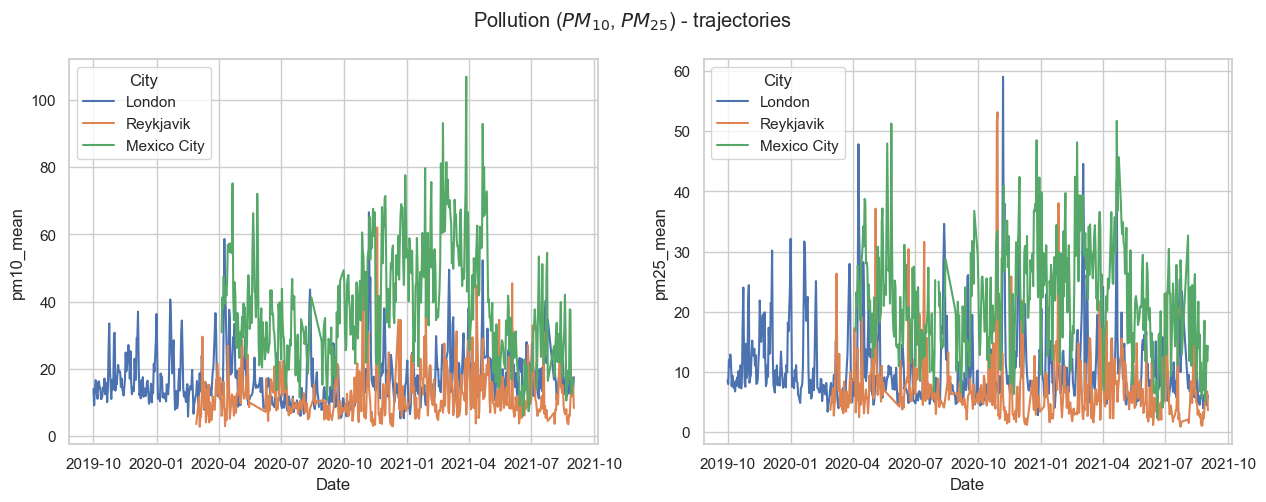

In [7]:
# Set the theme for seaborn
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Pollution ($PM_{10}$, $PM_{25}$) - trajectories')

# pm10_mean
sns.lineplot(ax=axes[0],x="Date", y="pm10_mean", hue="City", data=df_all) 

# pm25_mean
sns.lineplot(ax=axes[1],x="Date", y="pm25_mean", hue="City", data=df_all) 

plt.show()

#### Analysis

The plot above shows how pollution varies with time for the three cities in question. Namely, there seems to be a large increase in pollution during 2019 before reducing rather dramatically. 

This could be due to COVID or policy changes. The data seems to be quite volatile, however, trends can be seen and monthly moving average plotted to make easier analysis of trends. 

#### Analysis

The plot above shows how the mean levels of PM_25 vary with time. This graph is interesting as it highlights some of the issues we have found with data. Data for some cities, namely non-government produced data has outliers. It would be hard to belive that the daily pm25 average rose from close to 30 to over 300 in one day. 

This led up to clean data and check for outliers within the API before building or regression model. When examining other cities it was noted that outlier were more common for smaller cities and cities in less economicall developed countries which may suggest reporting issues.

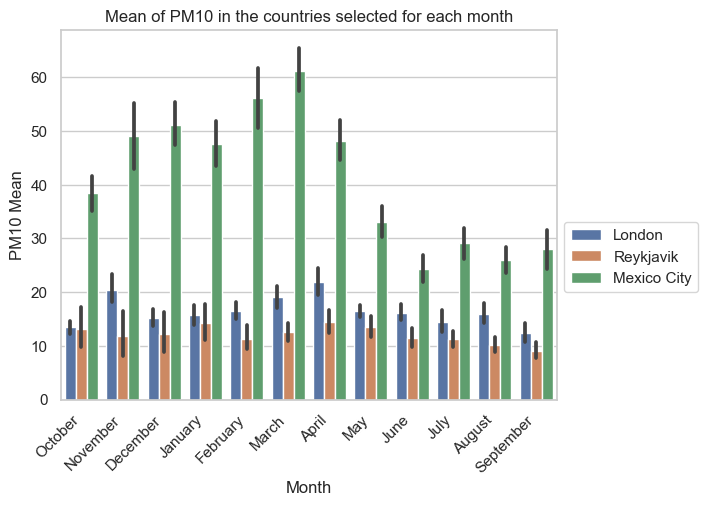

In [8]:
# Create a barplot, with month on the x axis, and pm10 mean on the y axis, 
# from the dataframe df_all, 'hue' helps to differentiate each country
ax = sns.barplot(x="month_string", y="pm10_mean", hue="City", data=df_all)  
                                                                           
# Rotate the name of the x axis                                                            
ax.set_xticklabels(ax.get_xticklabels(),                                   
                          rotation=45,                                    
                          horizontalalignment='right') 

# Put the legends outside the plot
plt.legend(bbox_to_anchor=(1, 0.5)) 
# Set title
plt.title('Mean of PM10 in the countries selected for each month')
# Set name of x axis
plt.xlabel("Month")
# Set name of y axis
plt.ylabel("PM10 Mean")
# show plot
plt.show()                                                                 

#### Analysis

As we can see from the plot above, it appears that for all three cities in question pollution declines during the summer months before increasing towards the winter months. The effect is most pronounced for Mexico, however, it can still be seen for London and Reykjavik. 

From initial analysis it would appear the month has a big impact on pollution and we hypothesise this is related to weather patterns, energy consumption and travel patterns during these months, although further analysis is needed for concrete evidence of this.

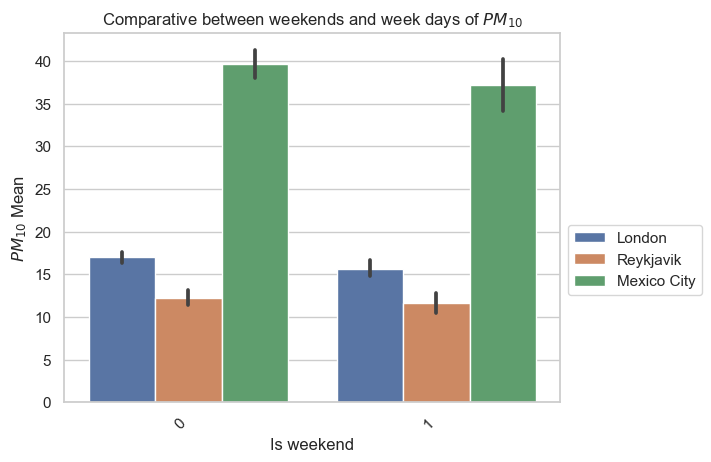

In [9]:
# Create a barplot, with Date on the x axis, and pm10 mean on the y, from the dataframe df_all 
ax = sns.barplot(x="is_weekend", y="pm10_mean", hue="City", data=df_all) 

# Rotate the name of the x axis                                                          
ax.set_xticklabels(ax.get_xticklabels(),                                   
                          rotation=45,                                     
                          horizontalalignment='right')

#Put the legends outside the plot
ax.legend(bbox_to_anchor=(1, 0.5)) 

# Set title
plt.title('Comparative between weekends and week days of $PM_{10}$')
# Set name of x axis
plt.xlabel("Is weekend")
# Set name of y axis
plt.ylabel("$PM_{10}$ Mean")

# Print the plot
plt.show()                                                               

#### Analysis

The plot above suggests that there is a correlation between the day of the week and the amount of pollution. Again, for all cities pollution decreases on weekends. The effect is more pronounced for Mexico compared to London and Reykjavik. Given it is the second time we have seen this phenomenon we could claim that due to the larger population of Mexico the effects of day, week and month are more pronounced. 

The higher population on the weekends may be because industry and mining activities are lower, however, it must be noted that cultural differences may mean that this is not the case. Counter-intuitively, a higher amount of leisure activites on the weekend could increase pollution. The combined effect of this would suggest that industry contributes more to pollution than individuals do.

### Effect of GDP on pollution

In [10]:
# Read the CSV file of GDP
GDPPerCap = pd.read_csv('data/demographics/GDPPerCap.csv') 

# Select the columns and rows we are interested in 
GDPPerCap_int= GDPPerCap.iloc[0:3,0:4]               
# Change the type of variable year from number to str
GDPPerCap_int["Year"] = GDPPerCap_int["Year"].map(str)

# Change to numeric 
GDPPerCap_int["United Kingdom"] = pd.to_numeric(GDPPerCap_int["United Kingdom"]) 
GDPPerCap_int["Mexico"] = pd.to_numeric(GDPPerCap_int["Mexico"])                
GDPPerCap_int["Iceland"] = pd.to_numeric(GDPPerCap_int["Iceland"]) 

In [11]:
# Select rows from the complete dataset and rename to GDP for Iceland
GDPPerCap_ice = GDPPerCap_int[['Year','Iceland']].rename(columns={"Iceland": "GDP"})    
# Create a new column called City in the dataframe GDP
GDPPerCap_ice['City'] = 'Reykjavik'                                                                  

# Select rows from the complete dataset and rename to GDP for Mexico
GDPPerCap_mex = GDPPerCap_int[['Year','Mexico']].rename(columns={"Mexico": "GDP"})  
# Create a new column called City in the dataframe GDP
GDPPerCap_mex['City'] = 'Mexico City'                                                              

# Select rows from the complete dataset and rename to GDP for UK
GDPPerCap_lon = GDPPerCap_int[['Year','United Kingdom']].rename(columns={"United Kingdom": "GDP"})
# Create a new column called City in the dataframe GDP
GDPPerCap_lon['City'] = 'London'  

                           

In [12]:
# Create a frame with the new variable "city" which will be concatenate in the complete dataframe
frames = [GDPPerCap_lon, GDPPerCap_ice, GDPPerCap_mex]  

# Concatenate the frame to the complete dataframe
df_all_GDP = pd.concat(frames)

                                                

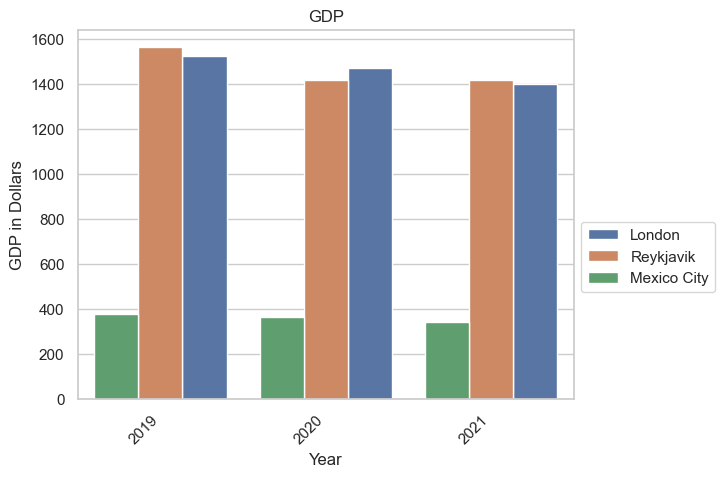

In [13]:
# Create a barplot for the GDP, with year on the x axis, and GDP on the y axis
ax = sns.barplot(x="Year", y="GDP", hue="City", data=df_all_GDP)    
                                                                           
# Rotate labels                                                            
ax.set_xticklabels(ax.get_xticklabels(),                                   
                          rotation=45,                                     
                          horizontalalignment='right')    

# Put the legends outside the plot
ax.legend(bbox_to_anchor=(1, 0.5))

# Invert the x axis, so that the year increases from left to right
ax.invert_xaxis()

# Set title
plt.title('GDP')
# Set name of x axis
plt.xlabel("Year")
# Set name of y axis
plt.ylabel("GDP in Dollars")

# print the plot
plt.show()                                                                 

#### Analysis

The chart above shows how GDP levels have differed for the previous three years and highlights the differing levels of economic development.

The aim of this plot is to show the possible relationship between the economy of the countries (Mexico, Iceland and UK) and the pollutants. The hypothesis is that the better the economy of a country, the lower the pollutants

### Effect of population on pollution

In [14]:
# Read the CSV file of population
population = pd.read_csv('data/demographics/Popn.csv')   

# Print dataframe
#population  

# Select the columns and rows we are interested in from the population dataframe
population_int= population.iloc[0:3,0:4]      

# Change the type of variable year from number to str
population_int["Year"] = population_int["Year"].map(str)                    

# Divide columns to work with small numbers
population_int['Pop_Lon'] = (population_int['London']/1000000)             
population_int['Pop_Mex'] = (population_int['Mexico city']/1000000)         
population_int["Pop_Ice"] = (population_int['Iceland']/1000000)         


In [15]:
# Select two rows from the complete dataset and rename to population
population_ice = population_int[['Year','Pop_Ice']].rename(columns={"Pop_Ice": "Population"}) 

# Create a new column called City that works only for Reykjavik
population_ice['City'] = 'Reykjavik'                                         

# Select two rows from the complete dataset and rename to population
population_mex = population_int[['Year','Pop_Mex']].rename(columns={"Pop_Mex": "Population"}) 
# Create a new column called City that works only for Mexico
population_mex['City'] = 'Mexico City'                                        

#Select two rows from the complete dataset and rename to population
population_lon = population_int[['Year','Pop_Lon']].rename(columns={"Pop_Lon": "Population"}) 
# Create a new column called City that works only for London
population_lon['City'] = 'London'                                             
                 

In [16]:
# Create a dataframe containing the new variable called City
frames = [population_lon, population_ice, population_mex]

# Concatenate the frame to the complete dataframe
df_all_pop = pd.concat(frames)                               
                                               

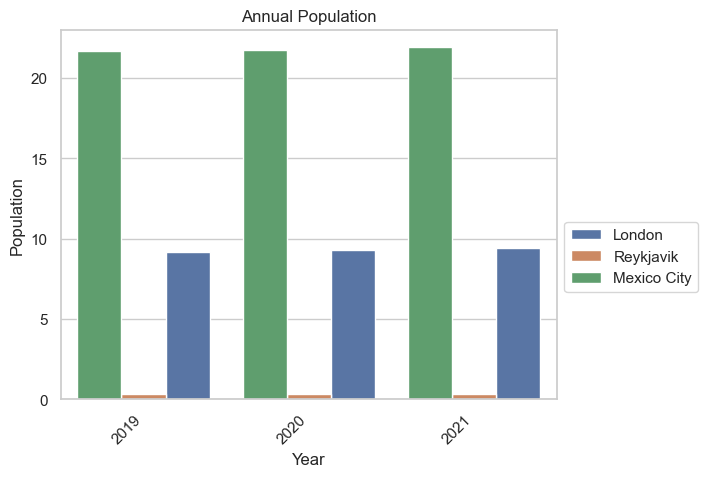

In [38]:
# Create a barplot, with year on the x axis, and population on the y axis, from the dataframe created  
ax = sns.barplot(x="Year", y="Population", hue="City", data=df_all_pop)    
                                                                           
# Rotate labels                                                           
ax.set_xticklabels(ax.get_xticklabels(),                                   
                          rotation=45,                                    
                          horizontalalignment='right')  

# Put the legends outside the plot
ax.legend(bbox_to_anchor=(1, 0.5))    

# Invert the x axis, so that year increases from left to right
ax.invert_xaxis()                                                          

# Set title
plt.title('Annual Population')
# Set name of x axis
plt.xlabel("Year")
# Set name of y axis
plt.ylabel("Population")

# print the plot
plt.show()                                                                

#### Analysis

As we can see from the graphs above, on a relative scale population does does not seem to be changing at a fast enough rate for each location to warrant data to be collected and analysed on a more frequent basis. While population data may have an impact on a city's pollution, the aim of this project is to create a pollution prediction for an individual city on a daily basis, where, the population growth rate would have little impact. 

### Effect of External Factors on pollution

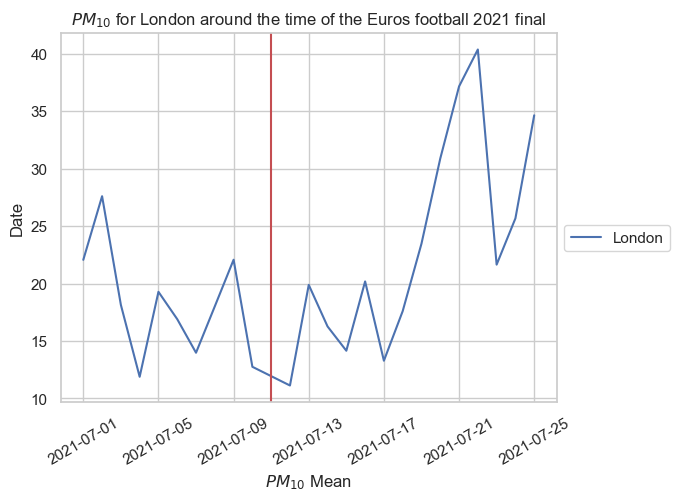

In [18]:
# Event - Euros final 2021
# Plotting whole month of July
# No obvious impact

# Set initialise event date and days to plot
event_date = pd.to_datetime('2021-07-11')
date_from = pd.to_datetime('2021-06-30')
date_to = pd.to_datetime('2021-08-01')

# Filter dataframe to the days we want to plot
df_london_event = df_london[df_london['Date'] > date_from] 
df_london_event = df_london_event[df_london_event['Date'] < date_to] 

# Plot the pollution for these days
ax = sns.lineplot(x="Date", y="pm10_mean",hue="City", data=df_london_event)
plt.axvline(event_date, 0, 50, color = 'r')
# Rotate labels
plt.xticks(rotation=30)

# Put the legends outside the plot
ax.legend(bbox_to_anchor=(1, 0.5))

# Set title
plt.title('$PM_{10}$ for London around the time of the UEFA Euro 2021 Final')
# Set name of x axis
plt.xlabel("$PM_{10}$ Mean")
# Set name of y axis
plt.ylabel("Date")

plt.show()

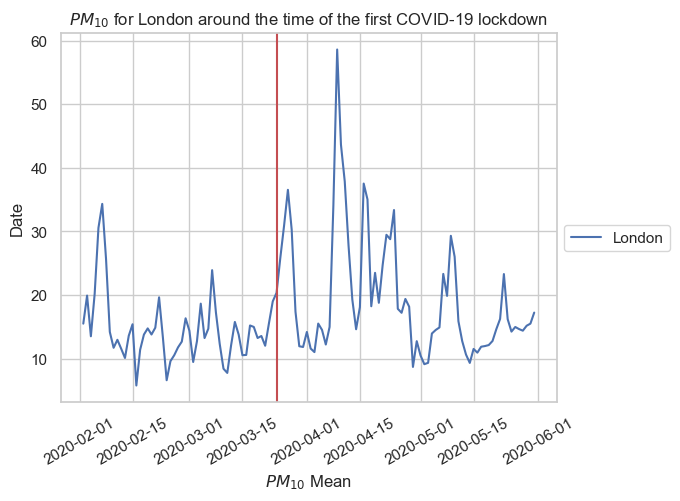

In [19]:
# Event - 1st lockdown
# Check approx 2 months before and approx 2 months after
# No obvious trend

# Sets event date and days to plot
event_date = pd.to_datetime('2020-03-24')
date_from = pd.to_datetime('2020-02-01')
date_to = pd.to_datetime('2020-06-01')

# Filters dataframe to only days we want
df_london_event = df_london[df_london['Date'] > date_from] 
df_london_event = df_london_event[df_london_event['Date'] < date_to] 

# Plot the pollution for these days
ax = sns.lineplot(x="Date", y="pm10_mean",hue="City", data=df_london_event)
plt.axvline(event_date, 0, 50, color = 'r')
# Rotate labels
plt.xticks(rotation=30)

# Put the legends outside the plot
ax.legend(bbox_to_anchor=(1, 0.5))

# Set title
plt.title('$PM_{10}$ for London around the time of the first COVID-19 lockdown')
# Set name of x axis
plt.xlabel("$PM_{10}$ Mean")
# Set name of y axis
plt.ylabel("Date")

plt.show()

### Effect of weather on pollution

#### Pollution and wind

Weather systems such as wind and sunlight can have an impact on air pollution. During the 1950's London was named 'pea soup'. This was because a combination of multiple particulates and sulphur dioxide and occured when winds were low. Moreover, events such as acid rain are more common with greater levels of humidity and sunlight or UV rays can neautralise some pollutants through the form of a chemical reaction.




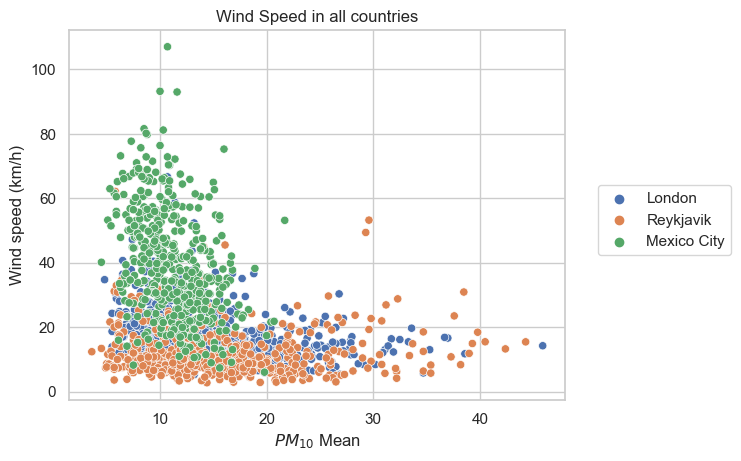

In [22]:
# Regression plot of the pm10 for all countries
sns.scatterplot(data=df_all, x="wspd", y="pm10_mean",hue="City") 

# Put the legends outside the plot
plt.legend(bbox_to_anchor=(1.35, .6))

# Set title
plt.title('Wind Speed in all countries')
# Set name of x axis
plt.xlabel("$PM_{10}$ Mean")
# Set name of y axis
plt.ylabel("Wind speed (km/h)")
# Print plot
plt.show()                                                      

#### Analysis

The chart above shows how windspeed affects mean levels of $PM_{10}$, there is somewhat of a correlation between the data as at lower winspeeds there are higher levels of pollution. Again the effects are more pronounced for Mexico, despite having a less windy environment. 

The results make intuative sense, as, with higher windspeeds pollution especially bigger particulates like $PM_{10}$ and $PM_{25}$ would be carried away either to other cities or to the sea. 

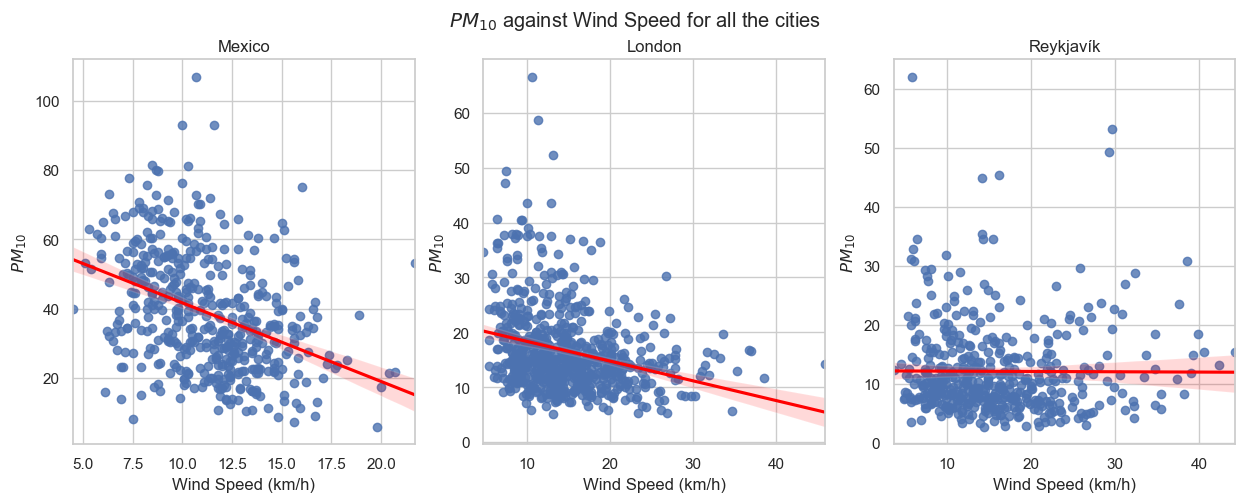

In [35]:
# Create a subplot with three figures for wind speed

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('$PM_{10}$ against Wind Speed for all the cities')


# Mexico
sns.regplot(ax = axes[0],data=df_mexico, x="wspd", y="pm10_mean",line_kws={"color": "red"})  
axes[0].title.set_text('Mexico')
axes[0].set_ylabel("$PM_{10}$")
axes[0].set_xlabel("Wind Speed (km/h)")

# London
sns.regplot(ax = axes[1],data=df_london, x="wspd", y="pm10_mean", line_kws={"color": "red"})
axes[1].title.set_text('London')
axes[1].set_ylabel("$PM_{10}$")
axes[1].set_xlabel("Wind Speed (km/h)")

# Reykjavik
sns.regplot(ax = axes[2],data=df_reykjavik, x="wspd", y="pm10_mean", line_kws={"color": "red"})
axes[2].title.set_text('Reykjavík')
axes[2].set_ylabel("$PM_{10}$")
axes[2].set_xlabel("Wind Speed (km/h)")

plt.show()

#### Analysis

Interestingly the chart above for Reykjavik shows less of a correlation between windspeed and pollution levels of $PM_{10}$. This could be due to the lower levels of $PM_{10}$ in Iceland as a result of lower amounts of slash and burn farming and fossil fuel production given the higher amount of geothermal energy. 

#### Pollution and temperature

The temperate of a country or city may also have a big impact on pollution. Hotter cities are often more prone to high levels of pollution as high temperatures are often associated with differing levels of pollution due to the movement of air. We hypothsise that hotter countries are prone to higher levels of pollution.



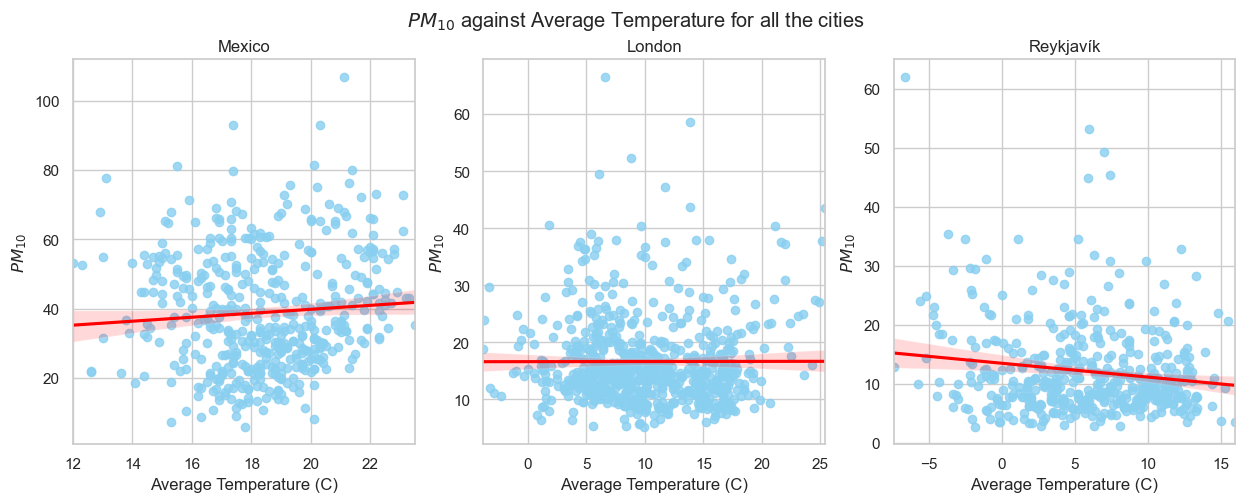

In [37]:
# Create a subplot with three figures for temperature
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('$PM_{10}$ against Average Temperature for all the cities')

# Mexico
sns.regplot(ax = axes[0],data=df_mexico, x="tavg", y="pm10_mean",
           scatter_kws={"color": "#89CFF0"}, line_kws={"color": "red"})  
axes[0].title.set_text('Mexico')
axes[0].set_ylabel("$PM_{10}$")
axes[0].set_xlabel("Average Temperature (C)")

# London
sns.regplot(ax = axes[1],data=df_london, x="tavg", y="pm10_mean",
           scatter_kws={"color": "#89CFF0"}, line_kws={"color": "red"})
axes[1].title.set_text('London')
axes[1].set_ylabel("$PM_{10}$")
axes[1].set_xlabel("Average Temperature (C)")

# Reykjavik
sns.regplot(ax = axes[2],data=df_reykjavik, x="tavg", y="pm10_mean",
           scatter_kws={"color": "#89CFF0"}, line_kws={"color": "red"})
axes[2].title.set_text('Reykjavík')
axes[2].set_ylabel("$PM_{10}$")
axes[2].set_xlabel("Average Temperature (C)")

plt.show()


# Regression

The final product of our report is a prediction model that outputs a probability that $PM_{10}$ or $PM_{25}$ will reach a certain limit for a given day. 

At first we wanted to build a prediction model that could predict pollution level of $PM_{10}$ and $PM_{25}$ without having to develop a specific model for each city. That is the model would take into account the demographic variables (population, GDP, Size, e.t.c). However, from the chapters above we can see that the relationship between those factors and pollution is not strong enough.

Instead we decided to focus on one city, London as a prototype, and build a classifier based on historical data from that city. The classifier chosen for this project is Logistic regression, other classifiers like, decision trees and support vector machines were also considered but logistic regression was chosen since it's well known and the interpretability of the model is simple.

Logistic regression takes an output from a linear function and uses the logistic function to create a response variable between 0 and 1. If we define $\eta$ as: 

$$\eta = X\beta$$

Where X is the predictor variables and beta is the parameters we want to estimate then logistic regression uses a link function called logistic and models the output as:

$$logistic(\eta) = \dfrac{1}{1+exp(-\eta)}$$

So we can interpret the probability that $PM_{10}$ or $PM_{25}$ will reach a certain limit as:

$$p(y_i = 1) = \dfrac{1}{1+exp(-(\beta_0+\beta_1x_1 + ... + \beta_px_p))}$$

Where p is the number of preditor variables in the model. The predictor variable $y_i$ is defined as:


* 1 if $PM_{10} > 40$ or $PM_{25} > 30$ 
* 0 otherwise

where $PM_{10}$ and $PM_{25}$ represent the average over the last 24-hours. Those cut-off values were chosen from a guide from the met office see: https://www.metoffice.gov.uk/weather/guides/air-quality. 


From the analysis above we decided to use therse predictor variables in the classifier:

* Month of year
* Is the day on a weekend
* Wind speed




In [24]:
# Move this up later
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [25]:
# Start by creating the response variable (1/0)
# Use cut-off values 40 for pm10_mean and 30 for pm25_mean

def is_pollution (row):
    '''
    Takes in rows from a data frame and creates a new column is_pollution (1/0) based on 
    other columns (pm10_mean,pm25_mean) from the data frame.
    '''
    if row['pm10_mean'] > 40 or row['pm25_mean'] > 30:
        return 1
    return 0

# Create the response variable
df_london['is_pollution'] = df_london.apply (lambda row: is_pollution(row), axis=1)

In [26]:
# Create a category data type for the "factor" variables 
# This is done so the creation of dummy variables
# will be easier when we predict for new data later on

# Possible values of the month_string varialbe
possible_categories_month = ['January','February','March','April','May','June',
                       'July','August','September','October','November','December']
# Possible values of the is_weekend variable
possible_categories_weekend = [0,1]

df_london['month_string'] = df_london['month_string'].astype(pd.CategoricalDtype(categories=possible_categories_month))
df_london['is_weekend'] = df_london['is_weekend'].astype(pd.CategoricalDtype(categories=possible_categories_weekend))

In [27]:
### Take care of NA values###

# Drop the NA lines ? Yes for london but not the others... should we take out wpgt??
df_london = df_london.dropna()

In [32]:
# Create the logistic regression model

# Create X-matrix (Design matrix) and y the response variable
X = df_london[['is_weekend','wspd','month_string']]
#X = final_df[['is_weekend','wspd','tavg']]
Y = df_london['is_pollution']
 
# Create dummy variable for categorical columns
X = pd.get_dummies(data=X, drop_first=True)

# Fit a logistic regression model
clf = LogisticRegression(random_state=0,max_iter=1000).fit(X, Y)

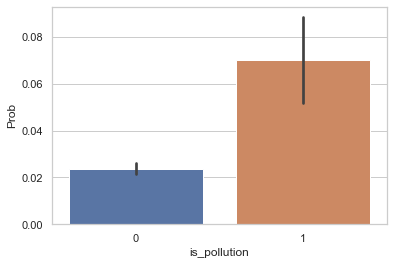

In [33]:

df_london['Prob'] = clf.predict_proba(X)[:,1]


# Predictions
ax = sns.barplot(x="is_pollution", y="Prob",data = df_london)

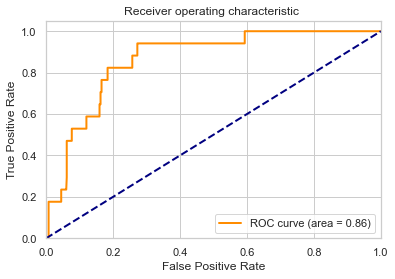

In [34]:
# Get predictions (of probabilities)
df_london['Prob'] = clf.predict_proba(X)[:,1]
y = df_london['is_pollution']
pred = df_london['Prob']

# Use the ROC curve to measure the accuracy of the model
fpr, tpr, thresholds = metrics.roc_curve(y, pred)


# True positive rate vs false positive rate
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % metrics.auc(fpr, tpr),
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

In [35]:
def model_prediction_london():
    '''
    Returns probability of whether London will have pollution 
    over a certain limit based on a classifier (1/0) dangerous or not
    in the next two days.
    
    Returns: Probability predictions for the next two days
    '''
    

    # Choose the city
    city = 'London'

    # Set time period
    start_date = date.today() + timedelta(days=1)
    end_date = date.today() + timedelta(days=2)

    # Call the weather API (See function at the start of report)
    date_from = pd.to_datetime(start_date)
    date_to = pd.to_datetime(end_date)
    Variables = fetch_data(city, 'weather', date_from=date_from, date_to= date_to)

    # Variable creation
    # Create the variables needed for the prediction

    Variables['Date'] = Variables.index
    Variables['month'] = pd.DatetimeIndex(Variables['Date']).month
    Variables['day'] = pd.DatetimeIndex(Variables['Date']).weekday
    Variables['month_string'] = Variables['month'].apply(month_to_string)
    Variables['is_weekend'] = Variables.apply (lambda row: is_weekend(row), axis=1)


    Variables['month_string'] = Variables['month_string'].astype(pd.CategoricalDtype(categories=possible_categories_month))
    Variables['is_weekend'] = Variables['is_weekend'].astype(pd.CategoricalDtype(categories=possible_categories_weekend))


    # Create X-matrix (Design matrix) and y the response variable
    X_prediction = Variables[['is_weekend','wspd','month_string']]

    # Create dummy variable for categorical columns
    X_prediction = pd.get_dummies(data=X_prediction, drop_first=True)

    return(clf.predict_proba(X_prediction)[:,1])

Predictions = model_prediction_london()


print(f'On {date.today() + timedelta(days=1)} there is: { "{:.2%}".format(Predictions[0])} probability of dangerous pollution in London')
print(f'On {date.today() + timedelta(days=2)} there is: { "{:.2%}".format(Predictions[1])} probability of dangerous pollution in London')

On 2021-12-09 there is: 1.64% probability of dangerous pollution in London
On 2021-12-10 there is: 1.24% probability of dangerous pollution in London


## Conclusion 

To conclude the model built looks at weather data for a set city and the day of the week and month and looks to predict pollution levels for a subsequent day. This is a prototye of a model that can be implemented to warn the public of higher levels of pollution on a given day thus protecting people who are more vunerable to respiritory diseases such as asthma. This was created in the hope to reduce excess deaths caused by air pollution globally. 

A pollution index was chosen to see if pollution levels were dangerous for use within the logistic regression model and this has scope to change as more scientific evidence emerages of what constitutes a dangerous level.

We originally looked at creating a model that could predict the level of pollution for any city, however, the complexity and bespoke nature of certain cities with respect the industry, cultural differences, demographics and natural phenomenon led us to creating a model for one city specifically. However, our ananlysis and code has been written so that it is easy to replicate for other cities. 

The variables included in the model have been chosen after looking for linear relationships between cities and varibles. While there maybe other variables of interest and more that could be added it was decided a deeper look into a few variables would lead to a more accurate model and one that is not uneccesarily complicated. Our model looks specifically at the day of the week and month and the weather in previous days to predict future levels of pollution. 

We have considered multiple adaptions for the model and we propose once the model has been justified that it take other variables. We found that events have a major impact on pollution levels. It would be desirebale to look directly at policy changes in a set country and add a dummy variable to indicate if an 'event' is happening to further increase or decrease the levels of pollution by a certain factor based on analysis. 
